In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time 

import qcodes
from qcodes.instrument_drivers.stanford_research.SR865 import SR865
from qcodes.instrument_drivers.QuTech.IVVI import IVVI

import pysweep
from pysweep import Measurement, sweep, utils

C:\Users\Administrator\Documents\development\qcodes_dev\qcodes\instrument\parameter.py:1315: UserWarning: Parameter single: `ManualParameter` is deprecated, use `Parameter` instead with `set_cmd=None`.
  '`Parameter` instead with `set_cmd=None`.'.format(self))


In [2]:
sr = SR865("sr", "GPIB0::4::INSTR")

Connected to: Stanford_Research_Systems SR860 (serial:003101, firmware:V1.47) in 0.15s


In [3]:
ivvi = IVVI("ivvi", "COM4")

Initialized IVVI-rack in 0.02s


In [4]:
station = qcodes.Station(sr, ivvi)

C:\Users\Administrator\Documents\development\qcodes_dev\qcodes\instrument\parameter.py:532: UserWarning: set_validator is deprected use `inst.vals = MyValidator` instead
  "set_validator is deprected use `inst.vals = MyValidator` instead")


In [5]:
pysweep.Measurement.set_station(station)

In [6]:
def setup(station, namespace): 
    station.sr.buffer.capture_config("X")
    station.sr.buffer.start_capture("ONE", "SAMP")
    return {}

def cleanup(station, namespace): 
    return {}

def stop_capture(station, namespace): 
    station.sr.buffer.stop_capture()
    return {}

def send_trigger(station, namespace, count): 
    station.ivvi.trigger()
    time.sleep(0.1)
    return {"trigger": {"unit": "-", "value": count, "independent_parameter": True}}

In [7]:
nsamples = 100
def measurement_function(station, namespace):
    data = station.sr.buffer.read_capture_data(nsamples)
    return {"measurement": {"unit": "V", "value":data["X"]}}

In [8]:
measurement = Measurement(
    setup, 
    cleanup, 
    [
        utils.sleep(0.1),
        sweep(send_trigger, range(nsamples)),
        stop_capture,
        measurement_function
    ]
)

In [9]:
Measurement.use_storage("json")
data = measurement.run()

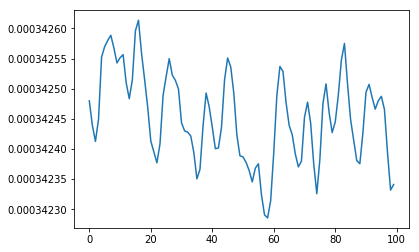

In [10]:
d = data.output("measurement")["measurement"]["value"]
t = data.output("trigger")["trigger"]["value"]

plt.plot(t, d)
plt.show()

In [11]:
def setup(station, namespace): 
    station.sr.buffer.capture_config("X")
    station.sr.buffer.start_capture("ONE", "SAMP")
    namespace.tcount = 0
    return {}

def send_trigger(station, namespace, count): 
    station.ivvi.trigger()
    namespace.tcount += 1
    time.sleep(0.1)
    return {"trigger": {"unit": "-", "value": count, "independent_parameter": True}}


def measurement_function(chuck_size, end=False):
    def inner(station, namespace):
        
        tcount = namespace.tcount
        data = []
        if end or (tcount != 0 and tcount % chuck_size == 0):
            
            station.sr.buffer.stop_capture()
            data = station.sr.buffer.read_capture_data(chuck_size)["X"]
            
            if not end:
                station.sr.buffer.start_capture("ONE", "SAMP")
                time.sleep(0.1)
        
            data = data.tolist()
        
        return {"measurement": {"unit": "V", "value":data}}
    
    return inner

In [20]:
Measurement.use_storage("spyview")

measurement = Measurement(
    setup, 
    cleanup, 
    [
        utils.sleep(0.1),
        sweep(send_trigger, range(200))(
            measurement_function(chuck_size=10)  # Write a chunck of 10 samples each time. 
        ),
        measurement_function(chuck_size=10, end=True)
    ]
)

data = measurement.run(delayed_parameters=["measurement"])

In [25]:
Measurement.use_storage("json")

measurement = Measurement(
    setup, 
    cleanup, 
    [
        utils.sleep(0.1),
        sweep(send_trigger, range(200))(
            measurement_function(chuck_size=10)  # Write a chunck of 10 samples each time. 
        ),
        measurement_function(chuck_size=10, end=True)
    ]
)

data = measurement.run()

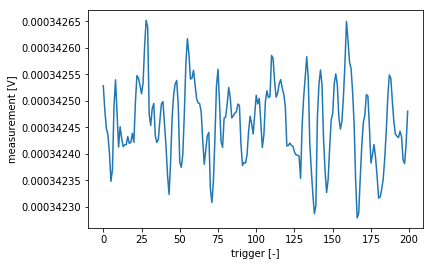

In [27]:
from pysweep.data_plot import DataPlot 
d = data.output("measurement")

DataPlot(d)
